In [1]:
# Imports and paths
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import os, json

from pathlib import Path
from ultralytics import YOLO
import cv2
import numpy as np

ROOT = Path(r"C:/Probook/E/AI/Projects/Image Processing/Vehicels/data/Vehicle_Detection_Image_Dataset")
IMAGES_DIR_VALID = ROOT / "valid" / "images"
IMAGES_DIR_TRAIN = ROOT / "train" / "images"


IMAGES_DIR = IMAGES_DIR_VALID if IMAGES_DIR_VALID.exists() else IMAGES_DIR_TRAIN


In [2]:
# Pick a sample image and video (fallbacks included)

IMG = ROOT / "sample_image.jpg"
if not IMG.exists():
    jpgs = list(IMAGES_DIR.glob("*.jpg"))
    IMG = jpgs[0] if jpgs else None


VID = ROOT / "sample_video.mp4"
if not VID.exists():
    vids = list(ROOT.glob("*.mp4")) + list(ROOT.glob("*.avi"))
    VID = vids[0] if vids else None

print("[Info] Selected image path:", IMG)
print("[Info] Images directory:", IMAGES_DIR)
print("[Info] Selected video path:", VID)

assert IMG is not None and IMG.exists(), "No image found. Double-check ROOT and your files."


[Info] Selected image path: C:\Probook\E\AI\Projects\Image Processing\Vehicels\data\Vehicle_Detection_Image_Dataset\sample_image.jpg
[Info] Images directory: C:\Probook\E\AI\Projects\Image Processing\Vehicels\data\Vehicle_Detection_Image_Dataset\valid\images
[Info] Selected video path: C:\Probook\E\AI\Projects\Image Processing\Vehicels\data\Vehicle_Detection_Image_Dataset\sample_video.mp4


In [3]:
# Model configuration and load

WEIGHTS = "yolov8l.pt"
IMG_SIZE = 1280
CONF = 0.45
IOU  = 0.80
MAX_DET = 1000
DEVICE = 0          
AUGMENT = True
CLASSES = [2, 3, 5, 7]  

print("[Info] Loading model:", WEIGHTS)
model = YOLO(WEIGHTS)
print("[OK] Model loaded.")


[Info] Loading model: yolov8l.pt
[OK] Model loaded.


In [4]:
# Run prediction on a single image

out_dir_img = Path("runs/detect/step1_image_overlap")
_ = model.predict(
    source=str(IMG),
    imgsz=IMG_SIZE,
    conf=CONF,
    iou=IOU,
    classes=CLASSES,
    device=DEVICE,
    max_det=MAX_DET,
    augment=AUGMENT,
    save=True,
    project="runs/detect",
    name="step1_image_overlap",
    exist_ok=True,
    show_conf=False
)
print("[Done] Image results saved to:", out_dir_img.resolve())



image 1/1 C:\Probook\E\AI\Projects\Image Processing\Vehicels\data\Vehicle_Detection_Image_Dataset\sample_image.jpg: 736x1280 6 cars, 3 trucks, 351.6ms
Speed: 11.7ms preprocess, 351.6ms inference, 158.4ms postprocess per image at shape (1, 3, 736, 1280)
Results saved to C:\Users\Asus\ENV\YOLOV8\vehicle detection\runs\detect\step1_image_overlap
[Done] Image results saved to: C:\Users\Asus\ENV\YOLOV8\vehicle detection\runs\detect\step1_image_overlap


In [5]:
# Run prediction on a video 
if VID is None or not Path(VID).exists():
    print("[Skip] No video found. Skipping video step.")
else:
    out_dir_video = Path("runs/detect/step3_video")
    _ = model.predict(
        source=str(VID),
        imgsz=IMG_SIZE,
        conf=CONF,
        iou=IOU,
        classes=CLASSES,
        device=DEVICE,
        max_det=MAX_DET,
        augment=False,   
        vid_stride=2,   
        save=True,
        project="runs/detect",
        name="step3_video",
        exist_ok=True,
        show_conf=False,
        verbose=False,
        stream=True
    )
    print("[Done] Video results saved to:", out_dir_video.resolve())


[Done] Video results saved to: C:\Users\Asus\ENV\YOLOV8\vehicle detection\runs\detect\step3_video


In [6]:
# Lite Evaluation:

SAMPLE_N = 10  
jpgs_all = sorted(IMAGES_DIR.glob("*.jpg"))
eval_imgs = jpgs_all[:SAMPLE_N] if len(jpgs_all) >= SAMPLE_N else jpgs_all

if not eval_imgs:
    raise SystemExit("[fatal] No images to evaluate in IMAGES_DIR")

names = model.names
cls_counter = Counter()
conf_values = []

rows = []  

for img_path in eval_imgs:
    results = model.predict(
        source=str(img_path), imgsz=IMG_SIZE, conf=CONF, iou=IOU,
        classes=CLASSES, device=DEVICE, max_det=MAX_DET, verbose=False, save=False
    )
    # aggregate
    total_det = 0
    img_conf = []
    img_cls_counter = Counter()

    for r in results:
        if r.boxes is None or len(r.boxes) == 0:
            continue
        for c, conf in zip(r.boxes.cls, r.boxes.conf):
            cname = names[int(c)]
            if cname not in ["car", "motorcycle", "bus", "truck"]:
                continue
            cls_counter[cname] += 1
            img_cls_counter[cname] += 1
            total_det += 1
            val = float(conf)
            conf_values.append(val)
            img_conf.append(val)

    rows.append({
        "image": img_path.name,
        "detections": total_det,
        "mean_confidence": round(float(np.mean(img_conf)) if img_conf else 0.0, 4),
        "car": img_cls_counter["car"],
        "motorcycle": img_cls_counter["motorcycle"],
        "bus": img_cls_counter["bus"],
        "truck": img_cls_counter["truck"],
    })

eval_df = pd.DataFrame(rows)
eval_dir = Path("runs/eval")
eval_dir.mkdir(parents=True, exist_ok=True)
eval_csv = eval_dir / "yolov8_inference_eval.csv"
eval_df.to_csv(eval_csv, index=False)

mean_conf_all = float(np.mean(conf_values)) if conf_values else 0.0
print("\n[Eval] Detections by class:", dict(cls_counter))
print(f"[Eval] Mean confidence (all detections): {mean_conf_all:.4f}")
print(f"[Eval] Saved per-image report → {eval_csv.resolve()}")



[Eval] Detections by class: {'car': 224, 'bus': 13, 'truck': 22, 'motorcycle': 3}
[Eval] Mean confidence (all detections): 0.7624
[Eval] Saved per-image report → C:\Users\Asus\ENV\YOLOV8\vehicle detection\runs\eval\yolov8_inference_eval.csv


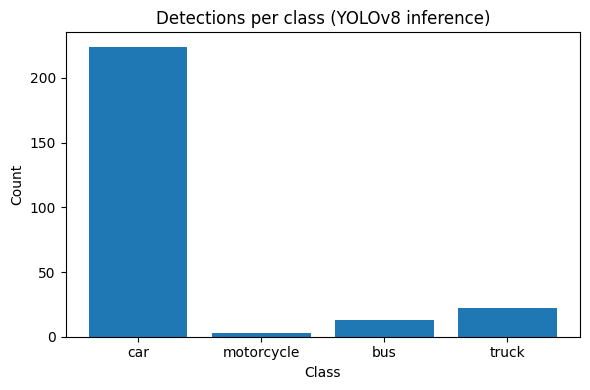

[Eval] Saved plot: C:\Users\Asus\ENV\YOLOV8\vehicle detection\runs\eval\detections_per_class.png
[Eval] Saved summary.json: C:\Users\Asus\ENV\YOLOV8\vehicle detection\runs\eval\summary.json


In [9]:
# Plot & Summary
cls_names = ["car", "motorcycle", "bus", "truck"]
counts = [cls_counter[c] for c in cls_names]

plt.figure(figsize=(6,4))
plt.bar(cls_names, counts)
plt.title("Detections per class (YOLOv8 inference)")
plt.xlabel("Class"); plt.ylabel("Count")
plt.tight_layout()

eval_dir = Path("runs/eval")
eval_dir.mkdir(parents=True, exist_ok=True)
plot_path = eval_dir / "detections_per_class.png"

plt.savefig(plot_path, dpi=150)
plt.show()

summary = {
    "images_evaluated": len(eval_df),
    "detections_by_class": dict(cls_counter),
    "mean_confidence_all": round(mean_conf_all, 4),
    "conf_threshold": CONF,
    "iou_threshold": IOU
}

with open(eval_dir / "summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("[Eval] Saved plot:", plot_path.resolve())
print("[Eval] Saved summary.json:", (eval_dir / "summary.json").resolve())
